In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd

from scipy.stats import boxcox

from foursquare import fetch_venue_likes

# Fetch and Transform Venue Likes

### Table of Contents

1. [Load Food Venues](#load-venues)

2. [Fetch Venue Likes](#venue-likes)
    
3. [Apply weights to Venue Likes buckets](#likes-weights)

### Inputs/Outputs
Required inputs:
- 'data/Bangkok_districts_food_venues.geojson' (as generated in './Bangkok_venues.ipynb')

Outputs:
- 'data/Bangkok_venue_likes.shp'
- 'data/Bangkok_venue_values.geojson'

## Load Food Venues
<a id='load-venues'></a>

In [2]:
venues_gdf = gpd.read_file('data/Bangkok_districts_food_venues.geojson',index_col=0)
venues_gdf

,city,id,name,category,geometry
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,POINT (100.08018 13.42733)
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,POINT (100.07984 13.42660)
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,POINT (100.09205 13.43016)
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,POINT (100.07888 13.44924)
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,POINT (100.07936 13.44986)
...,...,...,...,...,...
56384,Bangkok,4e5a1b4c52b1b78b81a5ab1d,เรือนรับรองโรงเรียนเตรียม,Thai Restaurant,POINT (101.12332 14.30844)
56385,Bangkok,4feab941e4b07f87a595eb68,ร้านกาแฟพี่กุ้ง,Coffee Shop,POINT (101.11967 14.30635)
56386,Bangkok,4fbdc0d8e4b06a0de5ba961b,ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร,Noodle House,POINT (101.12011 14.30625)
56387,Bangkok,5683b4e2498e95633f18c3bf,Wine I Love You Sweet Cafe,Donut Shop,POINT (101.11607 14.30994)


## Fetch Venue Likes
<a id='venue-likes'></a>

In [49]:
# Fetch venue likes and add to GeoDataFrame
for i,v in venues_gdf.iterrows():
    venues_gdf.loc[i,'likes']=fetch_venue_likes(v.id)

Status 404


In [53]:
# Drop three venues for which likes unfound
missing_likes = venues_gdf[venues_gdf.likes.isna()].index
venues_gdf.drop(missing_likes,inplace=True)

In [307]:
# Save likes to file
venues_gdf[['id','geometry','likes']].to_file('data/Bangkok_venue_likes.shp')

In [58]:
# Show range of number of likes
venues_gdf.likes.sort_values(ascending=False)

19721    1216.0
45572    1108.0
19722     870.0
25892     779.0
18718     742.0
          ...  
34151       0.0
34150       0.0
42696      -1.0
9877       -1.0
27269      -1.0
Name: likes, Length: 56386, dtype: float64

In [138]:
# Over half the venues have zero likes
(venues_gdf.likes==0).sum()

35816

In [62]:
# Exclude 3 venues with -1 likes
venues_gdf.drop(venues_gdf[venues_gdf.likes<0].index,inplace=True)

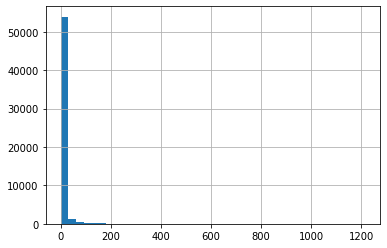

In [132]:
# Plot distribution of venue likes
venues_gdf.likes.hist(bins=40)

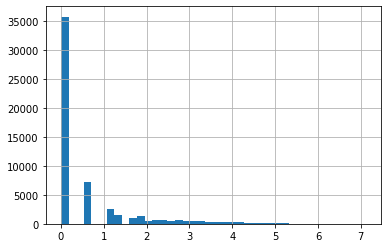

In [135]:
# Take log of 'likes' since its distribution is right-skewed
venues_gdf['log_likes']=np.log(venues_gdf.likes+1) # correct for many zeros - or try boxcox
venues_gdf.log_likes.hist(bins=40)

In [153]:
# Use power transform of 'likes' since log-transform is not powerful enough
bc = boxcox(venues_gdf.likes+1)

print('boxcox lambda:', bc[1])
venues_gdf['boxcox_likes'] = bc[0]

boxcox lambda: -1.1225846908253287


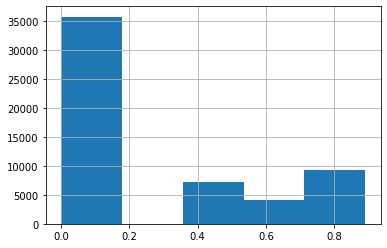

In [148]:
# Plot transformed venue value
venues_gdf.boxcox_likes.hist(bins=5)

In [160]:
# Since it is unlikely that greater than half of food venues provide zero value,
# convert boxcox_likes to ordinal values
venue_values=["zero","low","medium","high","highest"]
venues_gdf['venue_value'] = pd.cut(venues_gdf.boxcox_likes, 5, labels=venue_values)
venues_gdf

,city,id,name,category,geometry,likes,log_likes,boxcox_likes,venue_value
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,POINT (100.08018 13.42733),0.0,0.000000,0.000000,zero
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,POINT (100.07984 13.42660),0.0,0.000000,0.000000,zero
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,POINT (100.09205 13.43016),0.0,0.000000,0.000000,zero
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,POINT (100.07888 13.44924),0.0,0.000000,0.000000,zero
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,POINT (100.07936 13.44986),0.0,0.000000,0.000000,zero
...,...,...,...,...,...,...,...,...,...
56384,Bangkok,4e5a1b4c52b1b78b81a5ab1d,เรือนรับรองโรงเรียนเตรียม,Thai Restaurant,POINT (101.12332 14.30844),2.0,1.098612,0.631281,high
56385,Bangkok,4feab941e4b07f87a595eb68,ร้านกาแฟพี่กุ้ง,Coffee Shop,POINT (101.11967 14.30635),0.0,0.000000,0.000000,zero
56386,Bangkok,4fbdc0d8e4b06a0de5ba961b,ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร,Noodle House,POINT (101.12011 14.30625),0.0,0.000000,0.000000,zero
56387,Bangkok,5683b4e2498e95633f18c3bf,Wine I Love You Sweet Cafe,Donut Shop,POINT (101.11607 14.30994),0.0,0.000000,0.000000,zero


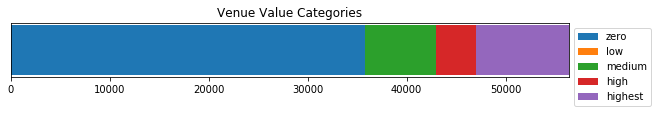

In [235]:
# Plot distribution of weighted venue values
N = len(venues_gdf)
height = 0.02
counts = venues_gdf.venue_value.value_counts()

zero_count = counts[venue_values[0]]
low_count = counts[venue_values[1]]
med_count = counts[venue_values[2]]
high_count = counts[venue_values[3]]
highest_count = counts[venue_values[4]]

fig = plt.figure(figsize=(10,1))
ax = plt.subplot(111)

bar_zero = ax.barh(0, zero_count, height)
bar_low = ax.barh(0, low_count, height, left=zero_count)
bar_med = ax.barh(0, med_count, height, left=low_count+zero_count)
bar_high = ax.barh(0, high_count, height, left=med_count+low_count+zero_count)
bar_highest = ax.barh(0, highest_count, height, left=high_count+med_count+low_count+zero_count)

ax.set_title('Venue Value Categories')
ax.set_xlim(0,N)
ax.set_yticks([])
ax.legend((bar_zero[0], bar_low[0], bar_med[0], bar_high[0], bar_highest[0]),\
           tuple(venue_values), loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [264]:
# Examine distribution
print("zero category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='zero'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='zero'].likes.max()))
print("low category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='low'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='low'].likes.max()))
print("medium category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='medium'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='medium'].likes.max()))
print("high category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='high'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='high'].likes.max()))
print("higheset category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='highest'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='highest'].likes.max()))

zero category range: 0.0 - 0.0
low category range: nan - nan
medium category range: 1.0 - 1.0
high category range: 2.0 - 3.0
higheset category range: 4.0 - 1216.0


## Apply weights to Venue Likes buckets
<a id='likes-weights'></a>

In [278]:
# After log transform, secondary category drops out with no members
# This also helps us maintain interpretability

venue_value_weights = {
    'zero': 0.25,
    'low': 0, # we expect none
    'medium': 0.5,
    'high': 0.75,
    'highest': 1
}

venues_gdf['venue_value_weight'] = venues_gdf.venue_value.apply(lambda x: venue_value_weights[x])
venues_gdf

,city,id,name,category,geometry,likes,log_likes,boxcox_likes,venue_value,venue_value_weight
0,Bangkok,5d89ecb2ebc5f800083c9c72,วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...,Restaurant,POINT (100.08018 13.42733),0.0,0.000000,0.000000,zero,0.25
1,Bangkok,4f979611e4b0107577b7473d,น้ำดื่มไลออนคิงส์,Deli / Bodega,POINT (100.07984 13.42660),0.0,0.000000,0.000000,zero,0.25
2,Bangkok,4f019036c5126f14b907d325,ครัวแสงดาว,Seafood Restaurant,POINT (100.09205 13.43016),0.0,0.000000,0.000000,zero,0.25
3,Bangkok,4f2a1166e4b0d4e47d2b0990,อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก,Restaurant,POINT (100.07888 13.44924),0.0,0.000000,0.000000,zero,0.25
4,Bangkok,4ee0b7b80e01452f928d12ee,ลาบยโส ด่านช่างพระราม2 บางโทรัด สมุทรสาคร,Thai Restaurant,POINT (100.07936 13.44986),0.0,0.000000,0.000000,zero,0.25
...,...,...,...,...,...,...,...,...,...,...
56384,Bangkok,4e5a1b4c52b1b78b81a5ab1d,เรือนรับรองโรงเรียนเตรียม,Thai Restaurant,POINT (101.12332 14.30844),2.0,1.098612,0.631281,high,0.75
56385,Bangkok,4feab941e4b07f87a595eb68,ร้านกาแฟพี่กุ้ง,Coffee Shop,POINT (101.11967 14.30635),0.0,0.000000,0.000000,zero,0.25
56386,Bangkok,4fbdc0d8e4b06a0de5ba961b,ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร,Noodle House,POINT (101.12011 14.30625),0.0,0.000000,0.000000,zero,0.25
56387,Bangkok,5683b4e2498e95633f18c3bf,Wine I Love You Sweet Cafe,Donut Shop,POINT (101.11607 14.30994),0.0,0.000000,0.000000,zero,0.25


In [281]:
venues_gdf.venue_value_weight = venues_gdf.venue_value_weight.astype(float)
venues_gdf.venue_value_weight.dtype

dtype('float64')

In [302]:
venues_gdf[['id', 'category', 'geometry', 'likes', 'venue_value_weight']].to_file('data/Bangkok_venue_values.geojson', driver='GeoJSON')